In [2]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [18]:
%run pinn_utils.ipynb
%run PINN.ipynb

In [4]:
import pandas as pd
import numpy as np
import struct
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import math
import random
from ast import literal_eval

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print( tf.test.is_gpu_available())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


I0000 00:00:1745860931.844976  990180 gpu_device.cc:2022] Created device /device:GPU:0 with 1013 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:2f:00.0, compute capability: 8.6


In [1]:
with open("../tools/signal_1khz.bin", mode='rb') as file1:
    data = file1.read()
signal=np.asarray(struct.unpack('d'*int(len(data)/8), data))
plt.plot(signal, figsize=(5,5))

NameError: name 'np' is not defined

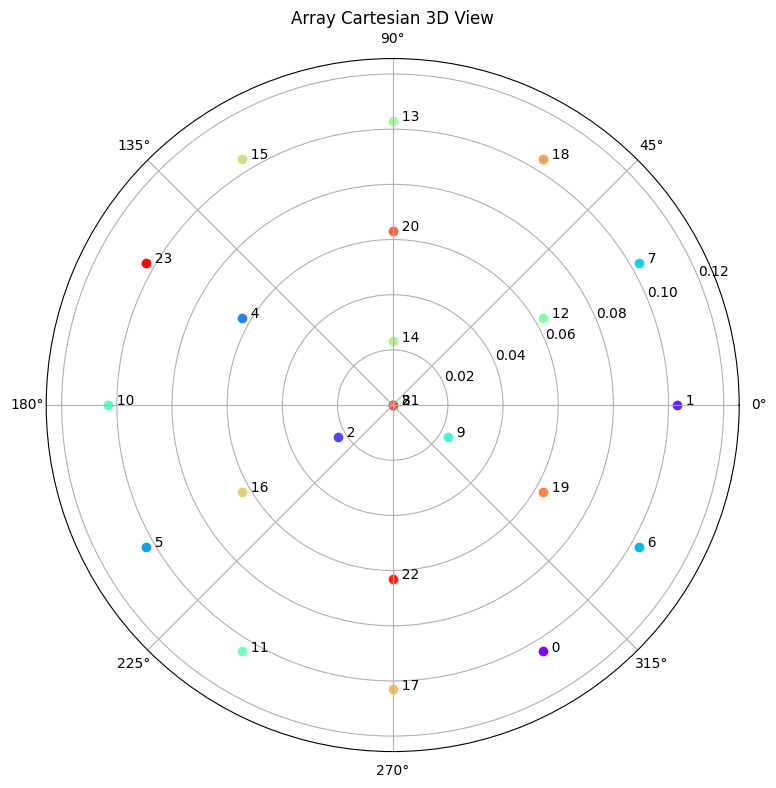

In [7]:
geometry = pd.read_csv('../tools/AA_geometry.tsv', header=None, sep='\t')
AA_Geometry = geometry.to_numpy()
visualizer = Visualizer(AA_Geometry)
visualizer.polar(fig_size=(10,9),save_dir = '../plot/')

In [8]:
path_dir = '../data/raw_rss360/'
data = DataExtract(path_dir, 24, 1400, AA_Geometry[:,:2])
space_time_pres_theta = data.get_data()

In [9]:
with tf.device('/CPU:0'):
    dataloader = DataLoader(space_time_pres_theta)
    train_dataloader, val_dataloader, test_dataloader = dataloader.split(shuffle=True,shuffle_buffer_size=5)

I0000 00:00:1745860945.249689  990180 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1013 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:2f:00.0, compute capability: 8.6


In [19]:
with tf.device('/CPU:0'):
    batch_size = 512
    epochs = 10
    model = PINN(24,floormod=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss=PINNLoss())
    loss = model.fit(train_dataloader.batch(batch_size), epochs = epochs, validation_data = val_dataloader.batch(batch_size), verbose=True)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lambda_data', 'lambda_phys', 'lambda_theta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1583/3829 ━━━━━━━━━━━━━━━━━━━━ 4:20 116ms/step - loss: 20.3084 - mae: 90.9929 - mse: 10905.2559

KeyboardInterrupt: 

In [24]:
space_time, pres, theta = next(iter(test_dataloader.batch(2)))
pres_pred, theta_pred = model(space_time, )
pres_pred.shape, theta_pred.shape

(TensorShape([2, 24]), TensorShape([2, 24]))

In [25]:
theta_pred, theta

(<tf.Tensor: shape=(2, 24), dtype=float32, numpy=
 array([[16.875402, 20.15869 , 16.624882, 14.727135,  8.683598, 14.082747,
         12.150738, 21.269442, 11.335819, 15.442324, 19.730217, 20.833149,
         12.148757, 16.357357,  4.43431 , 13.382903, 23.201786, 14.182828,
         12.228381, 11.645653, 13.672219, 11.23268 , 15.136535, 14.427972],
        [16.875402, 20.15869 , 16.624882, 14.727135,  8.683598, 14.082747,
         12.150738, 21.269442, 11.335819, 15.442324, 19.730217, 20.833149,
         12.148757, 16.357357,  4.43431 , 13.382903, 23.201786, 14.182828,
         12.228381, 11.645653, 13.672219, 11.23268 , 15.136535, 14.427972]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 24, 1), dtype=float32, numpy=
 array([[[135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],
         [135.8],


In [338]:
model.trainable_variables

[<Variable path=lambda_data, shape=(), dtype=float32, value=-1.206954836845398>,
 <Variable path=lambda_phys, shape=(), dtype=float32, value=-10.0>,
 <Variable path=lambda_theta, shape=(), dtype=float32, value=-4.972744941711426>,
 <Variable path=sequential_126/time_distributed_58/dense_310/kernel, shape=(3, 64), dtype=float32, value=[[-0.15413474  0.30518848 -1.6724128   0.98291093 -0.72357863  0.845344
    0.45712796 -1.1026871   0.0434998  -0.614789   -0.04656562 -0.68591124
   -0.13205785  0.1005505   0.28178084  0.356237    1.6710361  -0.19934079
    1.4494646   0.8160695   0.8441764   0.11685516 -0.17241049 -0.6769091
    0.6189576   1.1629931  -0.37106413 -0.6938051  -1.5620123  -0.09116375
   -1.0600632   0.3463621  -0.5201728  -0.7278653   0.7433498  -0.65648746
    1.2084714   1.0342104   0.74159783  1.0183859  -0.24314004  0.45703056
   -1.1125389  -0.19223525  1.2856785   1.1264666   0.14646849 -0.66286755
   -0.4419659  -0.02287432 -0.38514093 -0.04737807  0.39776003 -1.43

In [347]:
mean = tf.math.reduce_mean(space_time, axis=(0,1))
std = tf.math.reduce_std(space_time, axis=(0,1))
mean, std

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 1.5522043e-10, -4.1668923e-07,  1.5447907e-02], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.05694405, 0.05646188, 0.00194792], dtype=float32)>)

In [348]:
(space_time - mean)/std, space_time

(<tf.Tensor: shape=(2, 24, 3), dtype=float32, numpy=
 array([[[ 9.5953834e-01, -1.5812365e+00,  1.0000050e+00],
         [ 1.8103735e+00,  7.3800102e-06,  1.0000050e+00],
         [-3.5122195e-01, -2.0455542e-01,  1.0000050e+00],
         [-2.7258411e-09,  7.3800102e-06,  1.0000050e+00],
         [-9.5953834e-01,  5.5879152e-01,  1.0000050e+00],
         [-1.5678548e+00, -9.1299802e-01,  1.0000050e+00],
         [ 1.5678548e+00, -9.1299802e-01,  1.0000050e+00],
         [ 1.5678548e+00,  9.1301280e-01,  1.0000050e+00],
         [-2.7258411e-09,  7.3800102e-06,  1.0000050e+00],
         [ 3.5122195e-01, -2.0455542e-01,  1.0000050e+00],
         [-1.8103735e+00,  7.3800102e-06,  1.0000050e+00],
         [-9.5953834e-01, -1.5812365e+00,  1.0000050e+00],
         [ 9.5953834e-01,  5.5879152e-01,  1.0000050e+00],
         [-2.7258411e-09,  1.8258412e+00,  1.0000050e+00],
         [-2.7258411e-09,  4.0895587e-01,  1.0000050e+00],
         [-9.5953834e-01,  1.5812513e+00,  1.0000050e+00],
   

In [335]:
mean, std

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 9.7012771e-12, -4.1719855e-07,  1.2524750e-02], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.05694393, 0.05646191, 0.00882921], dtype=float32)>)